In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [5]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [6]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [7]:
# Reading channels
data = Data[1]
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [117]:
# Para el caso 1 canal
data = pd.read_csv('Data/1Channel.csv',sep=',')
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [118]:
def Gauss(x,mean=1.,sigma=0.1):
    return norm.pdf(x,loc=mean,scale=sigma)

In [119]:
def LogLikelihood(p,mu,n,b,s):

    e = p

    r = 1e-5
    lambda_ = mu*s + e*b + r
    
    log_likelihood = -lambda_ + n * np.log(lambda_) - gammaln(n+1)
    
    return log_likelihood

In [120]:
def GetJointLogLikelihood(p,n,b,s,sigmab=0.1):

    mu,e = p
    JointLog = 0.
    
    for c in range(N):             
        JointLog += LogLikelihood(e,mu,n[c],b[c],s[c])
        # Background uncertainty   
        JointLog += np.log(Gauss(e,1.,sigmab))
            
    return -JointLog

In [121]:
def GetJointLogLikelihoodNuissance(p,mu,n,b,s,sigmab=0.1):

    e = p
    JointLog = 0.
    for c in range(N):

        JointLog += LogLikelihood(p,mu,n[c],b[c],s[c])
        # Background uncertainty
        JointLog += np.log(Gauss(e,1.,sigmab))
            
    return -JointLog

In [122]:
mu = np.linspace(0.05,2.,20)
LogLike = GetJointLogLikelihoodNuissance(1.0,mu,n,b,s,0.1)

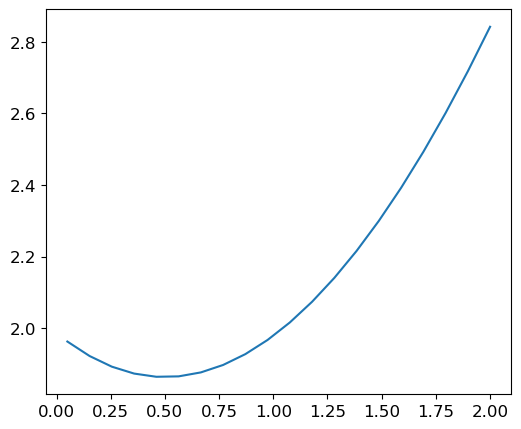

In [123]:
plt.plot(mu,LogLike)

In [124]:
def GetHat(n,b,s,sigmab=0.1):

    bounds = ((0,50),(0,10))
    p0 = np.array([1.,1.])
    result = spo.minimize( GetJointLogLikelihood, p0, args=(n,b,s,sigmab), bounds=bounds, options={"disp":False}, method='Nelder-Mead' )
    Hat = result.x

    return Hat

In [125]:
def GetDoubleHat(mu,n,b,s,sigmab=0.1):
    
    bounds =  ((0,10),)
    p0 = np.array([1.])
    result = spo.minimize( GetJointLogLikelihoodNuissance, p0, args=(mu,n,b,s,sigmab), bounds=bounds, options={"disp":False}, method='Nelder-Mead' )
    Doublehat = result.x[0]

    return Doublehat

In [126]:
# Probando
GetDoubleHat(1.5,n,b,s,0.3)

0.9105468749999999

In [127]:
GetHat(n,b,s,0.3)

array([0.50003274, 0.99999695])

In [128]:
# Probando funciones hat and double hat

In [129]:
def GetqmObs(mu,n,b,s,sigmab=0.1):

    doublehat = GetDoubleHat(mu,n,b,s,sigmab)
    hat = GetHat(n,b,s,sigmab)
    muhat,ehat = hat[0],hat[1]
    
    qm = 0.
    
    for c in range(N):
        
        if mu > muhat:
            qm += -2*(LogLikelihood(doublehat,mu,n[c],b[c],s[c]) - LogLikelihood(ehat,muhat,n[c],b[c],s[c]))
            qm += -2*( np.log(Gauss(doublehat,1,sigmab)) - np.log(Gauss(ehat,1,sigmab)) )
        else:
            qm += 0.
            
    return qm

In [81]:
qmObs = GetqmObs(1.0,n,b,s)
qmObs

2.9489826836465225

In [82]:
# Expected
qmObsE = GetqmObs(1.0,b,b,s)
qmObsE

5.135045031818867

In [137]:
mu = np.linspace(1.5,5.0,20)
qmObsEV = np.zeros_like(mu)
qmObsEV1 = np.zeros_like(mu)
qmObsEV2 = np.zeros_like(mu)

for i in range(mu.shape[0]):
    qmObsEV[i] = GetqmObs(mu[i],n,b,s,sigmab=0.05)
    qmObsEV1[i] = GetqmObs(mu[i],n,b,s,sigmab=0.1)
    qmObsEV2[i] = GetqmObs(mu[i],n,b,s,sigmab=0.2)

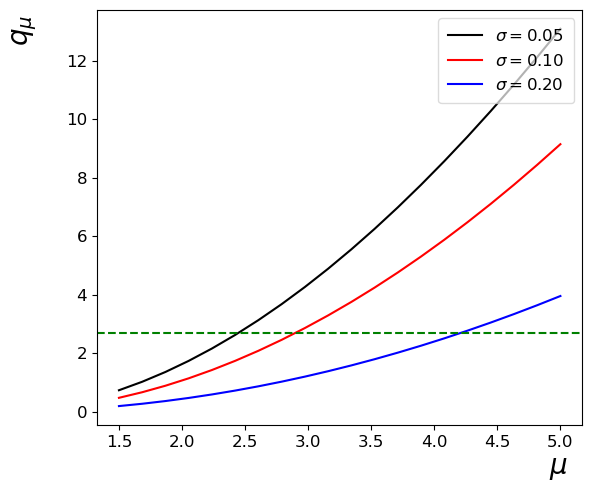

In [138]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(mu,qmObsEV,color='k',label=r'$\sigma=$%.2f'%(0.05))
ax.plot(mu,qmObsEV1,color='r',label=r'$\sigma=$%.2f'%(0.1))
ax.plot(mu,qmObsEV2,color='b',label=r'$\sigma=$%.2f'%(0.2))

ax.axhline(y=norm.ppf(0.95)**2,ls='--',color='g')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$q_{\mu}$')
ax.yaxis.set_label_coords(-0.12,0.95)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')


#
plt.savefig('qm_plot_systematic.pdf')

In [139]:
def Getqm(mu,sigmab=0.1,Null=True):
    
    Ntoys = np.zeros(N)
   
    for c in range(N):
        
        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson(mu*s[c]+b[c])
          
        Ntoys[c] = ntoy
            
    return GetqmObs(mu,Ntoys,b,s,sigmab)

In [140]:
def Sampler(mu,Ntoys = int(3e2),sigmab=0.1):
    
    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)
    
    for i in range(Ntoys):
        q0[i] = Getqm(mu,sigmab,Null=True)
        q1[i] = Getqm(mu,sigmab,Null=False)
        
    return q0,q1

In [141]:
#q0,q1 = Sampler(2,sigmab=0.1)
#_ = plt.hist(q0,bins=50,density=True)
#_ = plt.hist(q1,bins=50,density=True)

In [142]:
def GetPValue(data,Qobs):

    count_above_threshold = np.sum( data >= Qobs )
    p_value = count_above_threshold / data.shape[0]

    return p_value

In [143]:
def GetCls_for_mu(i,mu, Expected=False, sigmab = 0.1):

    if Expected:
        qmObs = GetqmObs(mu,b,b,s,sigmab)
    else:
        qmObs = GetqmObs(mu,n,b,s,sigmab)
            
    q0,q1 = Sampler(mu,sigmab=sigmab)

    p0 = GetPValue(q0,qmObs)
    p1 = GetPValue(q1,qmObs)

    if p0 != 0:
        Cls = p1/p0
    else:
        print('Problemas con la hipotesis nula')
        Cls = p1

    return i,Cls

In [144]:
#GetCls_for_mu(0,2.5,sigmab=0.2)

In [145]:
def GetCls_parallel(mu, Expected=False, sigmab = 0.1,num_processors=None):

    p_value = np.zeros_like(mu)

    with ProcessPoolExecutor(max_workers=num_processors) as executor:

        futures = np.array([])

        # Crear las tareas (futuras) para cada valor de mu
        for i in range(mu.shape[0]):
            futures = np.append(futures,executor.submit(GetCls_for_mu, i, mu[i], Expected=Expected, sigmab=sigmab))

        # Recolectar los resultados a medida que se completan
        for future in tqdm(as_completed(futures), total=len(futures)):
            i, Cls = future.result()
            p_value[i] = Cls

    return p_value

In [147]:
# Upper limit
def GetUpperLimit(mu,Cls,alpha = 0.05):

    i = np.where( Cls <= alpha )

    if len(i[0]) == 0:
        print('--- Cls is never less than alpha --- ')
        return 0.
    else:
        i = i[0][0]

    # Saving the indez where pvalues is less than the critical value

    x0 = mu[i-1]
    x1 = mu[i]
    fx0 = Cls[i-1]
    fx1 = Cls[i]

    # Compute the slope
    m = (fx1-fx0)/(x1-x0)

    if m == 0:
        print('--- Problem with the scan ---')
        return 0.

    # 1D Polynomial interpolation
    mup = (alpha - fx0)/m + x0

    return mup

In [148]:
mu = np.linspace(1.5,5.0,10)

In [149]:
Op_value = GetCls_parallel(mu,Expected=False,sigmab=0.1,num_processors=8)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


In [150]:
Op_value1 = GetCls_parallel(mu,Expected=False,sigmab=0.2,num_processors=8)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.91s/it]


In [151]:
GetUpperLimit(mu,Op_value)

2.6265410286611703

In [152]:
GetUpperLimit(mu,Op_value1)

2.6265410286611703

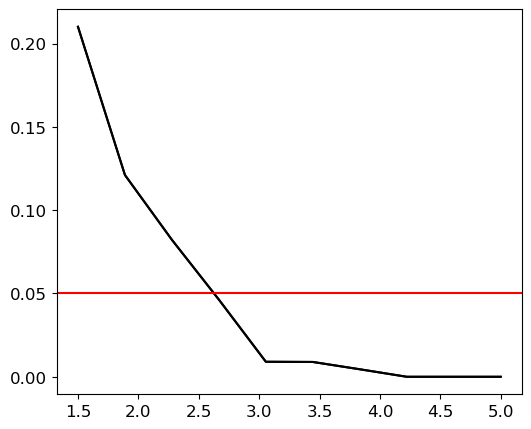

In [153]:
plt.plot(mu,Op_value,color='k')
plt.plot(mu,Op_value1,color='k')
plt.axhline(y=0.05,color='r')

In [192]:
# Estructura de datos para guardar
MatrizDatos = np.zeros((Mass.shape[0],7))
MatrizDatos[:,0] = Mass
MatrizDatos

array([[100.,   0.,   0.,   0.,   0.,   0.,   0.],
       [106.,   0.,   0.,   0.,   0.,   0.,   0.],
       [112.,   0.,   0.,   0.,   0.,   0.,   0.],
       [118.,   0.,   0.,   0.,   0.,   0.,   0.],
       [124.,   0.,   0.,   0.,   0.,   0.,   0.],
       [130.,   0.,   0.,   0.,   0.,   0.,   0.],
       [136.,   0.,   0.,   0.,   0.,   0.,   0.],
       [142.,   0.,   0.,   0.,   0.,   0.,   0.],
       [148.,   0.,   0.,   0.,   0.,   0.,   0.],
       [154.,   0.,   0.,   0.,   0.,   0.,   0.],
       [160.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [101]:
for i, data in enumerate(Data):

    print('--- Estimating Limits for ---', Mass[i])
    labels = list(data.keys())
    n = np.array(data[labels[0]])
    b = np.array(data[labels[1]])
    s = np.array(data[labels[2]])
    N = n.shape[0]

    # SetPOI scan
    mu = np.linspace(0.1,2,10)
    Op_value = GetCls_parallel(mu,Expected=False,num_processors=8)
    Ep_value = GetCls_parallel(mu,Expected=True,num_processors=8)

    ExpectedLimit = GetUpperLimit(mu,Ep_value)
    ObservedLimit = GetUpperLimit(mu,Op_value)

    # For Errors
    Qm = GetqmObs(ExpectedLimit,b,b,s)
    sigma = ExpectedLimit / np.sqrt(Qm)

    
    MatrizDatos[i,1] =  2*sigma    
    MatrizDatos[i,2] =  1*sigma
    MatrizDatos[i,3] = ExpectedLimit
    MatrizDatos[i,4] = 1*sigma
    MatrizDatos[i,5] = 2*sigma
    # Observed Limit
    MatrizDatos[i,6] = ObservedLimit

--- Estimating Limits for --- 100.0


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 8/10 [02:08<00:32, 16.12s/it]Process ForkProcess-12:
Process ForkProcess-13:
Process ForkProcess-16:
Process ForkProcess-15:
Process ForkProcess-10:
Process ForkProcess-11:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/alejandro/

KeyboardInterrupt: 

  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alejandro/anaconda3/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alejandro/anaconda3/lib/python3.11/concurrent/futures/process.py", line 244, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/queues.py", line 102, in get
    with self._rlock:
  File "/home/alejandro/anaconda3/lib/python3.11/multiprocessing/synchronize.py", line 95, in 

In [29]:
DataFinal = pd.DataFrame(MatrizDatos)
DataFinal.columns = ['Mass','-2sigma','-1sigma','Expected','+1sigma','+2sigma','Observed']
DataFinal

,Mass,-2sigma,-1sigma,Expected,+1sigma,+2sigma,Observed
0,100.0,0.886415,0.443208,0.882298,0.443208,0.886415,0.739911
1,106.0,0.555314,0.277657,0.581550,0.277657,0.555314,0.489799
2,112.0,0.544375,0.272188,0.573112,0.272188,0.544375,0.572979
3,118.0,0.483921,0.241961,0.511386,0.241961,0.483921,1.120789
4,124.0,0.435339,0.217669,0.463232,0.217669,0.435339,1.403922
5,130.0,0.394204,0.197102,0.438148,0.197102,0.394204,0.881879
6,136.0,0.366350,0.183175,0.390781,0.183175,0.366350,0.438574
7,142.0,0.330437,0.165219,0.336590,0.165219,0.330437,0.297902
8,148.0,0.315076,0.157538,0.307437,0.157538,0.315076,0.440832
9,154.0,0.273804,0.136902,0.296279,0.136902,0.273804,0.440135


In [30]:
DataFinal.to_csv('UpperLimitMassScanqm.csv',index=False)

<Axes: xlabel='Mass', ylabel='Expected'>

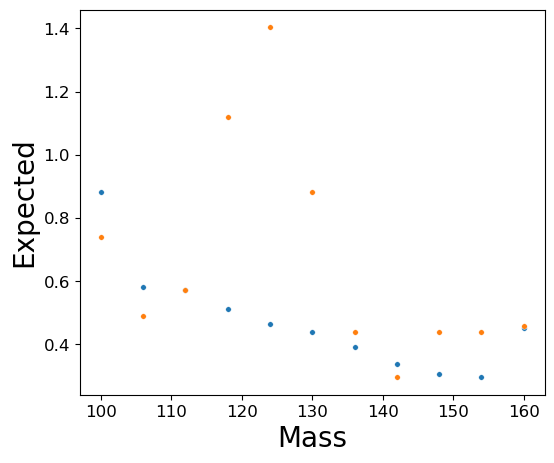

In [31]:
import seaborn as sns
sns.scatterplot(x='Mass',y='Expected',data = DataFinal)
sns.scatterplot(x='Mass',y='Observed',data = DataFinal)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


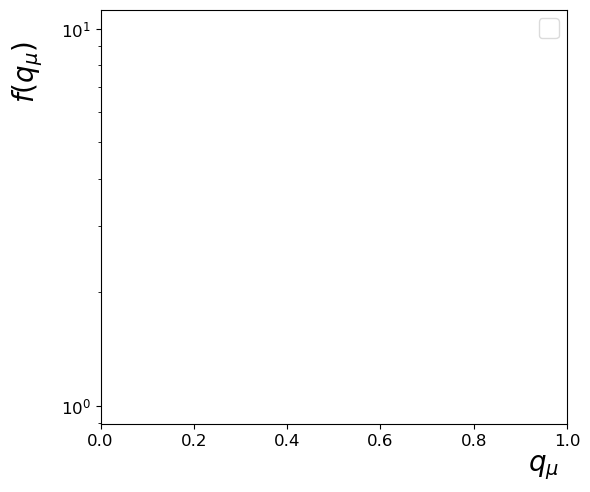

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.hist(q0,bins=35,color='green',density=True,label=r'$f(q_{\mu};0)$')
#ax.hist(q1,bins=35,color='yellow',density=True,label=r'$f(q_{\mu};\mu)$')
#ax.axvline(x=qmObs,color='k',label=r'$q_{\mu,obs}$')

# Label X
ax.set_xlabel(r'$q_{\mu}$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$f(q_{\mu})$')
ax.yaxis.set_label_coords(-0.12,0.85)

ax.set_yscale('log')

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
#plt.savefig('Distribution_qm.pdf')